In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

In [4]:
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))                                
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))                                
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
data_iter = iter(train_dataloader)

In [8]:
imgs, labels = data_iter.next()

In [9]:
labels

tensor([4, 9, 0, 4, 5, 3, 2, 6, 5, 5, 0, 8, 6, 8, 9, 7, 1, 5, 3, 5, 0, 5, 3, 3,
        4, 3, 0, 5, 1, 5, 1, 0])

In [10]:
imgs.size()

torch.Size([32, 3, 32, 32])

In [11]:
img = imgs[0]

In [12]:
img_permute = img.permute(1, 2, 0)

In [13]:
img_permute = 0.5 * img_permute + 0.5

In [14]:
img_permute = np.clip(img_permute, 0, 1)

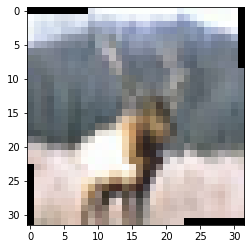

In [15]:
plt.imshow(img_permute)

In [16]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [17]:
model = CNN(10)
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [19]:
num_epochs = 15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)
    #
    # test loop
    #
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in test_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(test_dataloader)
    val_running_acc /= len(test_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)
    print("epoch: {}, loss: {}, acc: {}, \
     val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 1.433305179813468, acc: 0.47696736454963684,      val loss: 1.0972439880950002, val acc: 0.6093250513076782
epoch: 1, loss: 1.0305320225460592, acc: 0.6342170238494873,      val loss: 0.9065422707091505, val acc: 0.682707667350769
epoch: 2, loss: 0.8761650123469584, acc: 0.6921985149383545,      val loss: 0.8051631742011244, val acc: 0.7189496755599976
epoch: 3, loss: 0.7819633651870379, acc: 0.7235084772109985,      val loss: 0.7636748775125692, val acc: 0.7327276468276978
epoch: 4, loss: 0.7313383280353827, acc: 0.7460412979125977,      val loss: 0.7061512276006583, val acc: 0.7598841786384583
epoch: 5, loss: 0.6902052811034124, acc: 0.7585172653198242,      val loss: 0.710792664140939, val acc: 0.7541933059692383
epoch: 6, loss: 0.6601356580824861, acc: 0.7694937586784363,      val loss: 0.6813203324905981, val acc: 0.769069492816925
epoch: 7, loss: 0.6379130195709505, acc: 0.7775911688804626,      val loss: 0.653992762390417, val acc: 0.776457667350769
epoch: 8, los

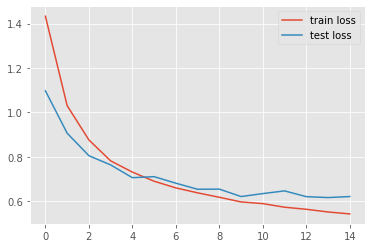

In [20]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="test loss")
plt.legend()

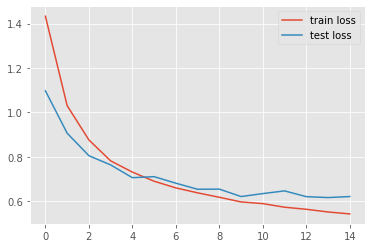

In [21]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="test loss")
plt.legend()

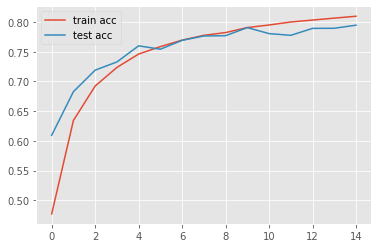

In [22]:
plt.plot(accs, label="train acc")
plt.plot(val_accs, label="test acc")
plt.legend()

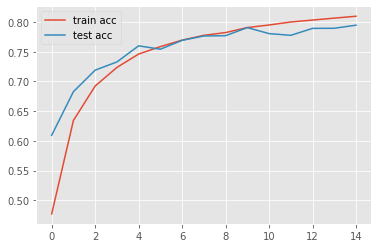

In [23]:
plt.plot(accs, label="train acc")
plt.plot(val_accs, label="test acc")
plt.legend()